# Notebook for the ENS Challenge Data 2022 - Qube Research & Technologies 

# **Learning factors for stock market returns prediction**

### Data preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path = '../' 

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

We have 50 stocks in the dataset and 754 days of returns for each stock.

In [3]:
print(f"X training shape {X_train.shape}, Y training shape: {Y_train.shape}")

X training shape (50, 754), Y training shape: (50, 504)


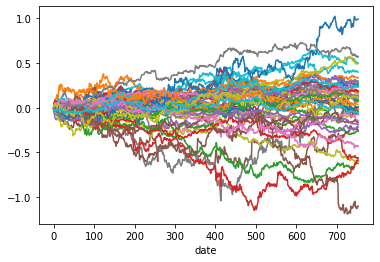

In [4]:
# The cumulative returns of the 50 stocks from the training data set over the three year period 

X_train.T.cumsum().plot(legend=False)
plt.show()

##### A useful data representation:

To speed up upcoming computations, we reshape the data  into a DataFrame with index (date, stock) and columns the lagged return values of the stock at time "date-1, ..., date-250".

In [5]:
X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis=1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')

In [6]:
X_train_nanincluded = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis=1)
X_train_nanincluded.columns = pd.Index(range(1,251), name='timeLag')

<AxesSubplot:xlabel='timeLag', ylabel='date-stocksID'>

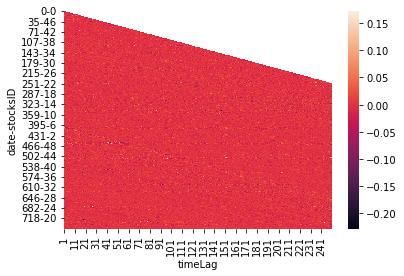

In [7]:
sns.heatmap(X_train_nanincluded)

<AxesSubplot:xlabel='timeLag', ylabel='date-stocksID'>

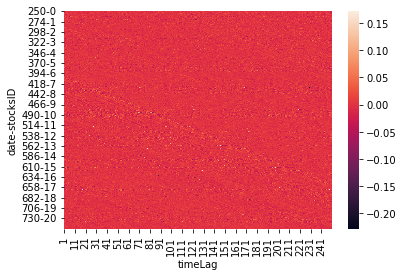

In [8]:
sns.heatmap(X_train_reshape)

The reason why the shape of this new datafram is (25200, 250) is because we have 754 days of returns for each stock and we have 50 stocks. So initially we have 754*50 = 37700 datapoints organised as 754 rows and 50 columns. We then calculate the lagged returns for the past 250 days and stack this data into a single column per day, hence the 250 rows in the final dataframe. We drop any rows with missing values so that is why the lagged returns begin at 250 days. (We can't calculate the lagged returns for the first 250 days because we don't have the returns for the 250 days prior to them!) We end up with $754-250 = 504$ rows of data for each stock, so we have $504*50 = 25200$ rows for each of the 250 lagged return columns. Hence the final dataframe's dimensions are (25200, 250). That's a whole lot of data!

In [9]:
X_train_reshape.shape

(25200, 250)

The motivation is that, given model parameters 'A' and 'beta', the associated predictions for Y_train are simply given by **Ypred = ( X_train_reshape @ A @ beta ).unstack().T**

# The prediction model

## Stiefel matrices

##### Example 1: autoregressive model AR(F)
Here we create an autographic model AR(F) with D=250 and F=10. The matrix only has values of 1 on the diagonal of the first F rows and 0 elsewhere.

In [10]:
def autoRegA(D=250, F=10):
    
    A = np.zeros((D,F))
    for i in range(F):
        A[i,i] = 1
    return A

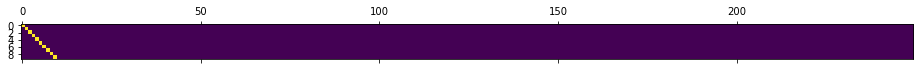

In [11]:
A = autoRegA()
plt.matshow(A.T)
plt.show()

##### Example 2: uniformly random Stiefel matrix A

Here we create a uniformly random Stiefel matrix A with D=250 and F=10. This just populates the matrix with random values between 

In [12]:
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return (randomStiefel, M)

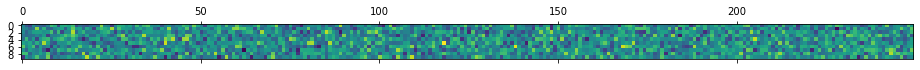

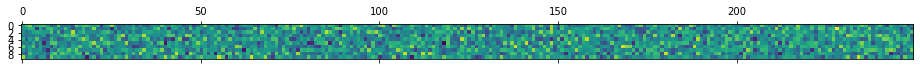

Min: -0.196 , Max: 0.209, Matrix norm: 3.162
Min: -3.358 , Max: 3.165, Matrix norm: 50.11


In [13]:
RandA, M = randomA()
plt.matshow(RandA.T) ## recall that these are the plots of the TRANSPOSE of the matrix A and M!
plt.matshow(M.T)
plt.show()
print(f"Min: {round(RandA.min(),3)} , Max: {round(RandA.max(),3)}, Matrix norm: {round(np.linalg.norm(RandA),3)}")
print(f"Min: {round(M.min(),3)} , Max: {round(M.max(),3)}, Matrix norm: {round(np.linalg.norm(M),3)}")

## Orthogonality checker

In [14]:
# to check the orthonormality constraints as in the metric:
    
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    if any(Error.unstack() > 1e-6):
        bool = False
     
    return bool

In [15]:
checkOrthonormality(A)

True

## Beta parameters

##### Example 1: "keep the $m$ first factor only" 

In [16]:
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

In [17]:
beta = firstBeta()
beta

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

##### Example 2: given a Stiefel matrix A, return the beta with minimal mean square prediction error on the training data set

In [18]:
def fitBeta(A):
    "The @ symbol is the matrix multiplication operator in Python"
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index F_{t,l} = R_{t+1-k} @ A_{k,l}
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()

In [19]:
fitBeta(A)

array([ 0.00623611, -0.00510036, -0.02025586, -0.00353405,  0.0088575 ,
        0.00473335,  0.01333769,  0.00205558, -0.00067165,  0.00917629])

## Metric on the training data set

The function **metric_train** below computes the *in sample* version of the metric for parameters 'A' and 'beta', using the accessible data sets 'X_train' and 'Y_train'. 

The true metric of the challenge is defined the same way except that we use the hidden data sets 'X_test' and 'Y_test' instead of 'X_train' and 'Y_train' (recall the latter contain the returns of 50 *other* stocks from the same stock market and on the *same* time period). 

In [44]:
def metric_train(A, beta): 
    
    if not checkOrthonormality(A): ## If we believe our update method is correct, this should never happen, but it may be useful for debugging
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T  # investigate which is faster: unstack or pivot and if it's easier to precompute any of this
    Ytrue = Y_train  # doesn't need to be calculated every time
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)  # This can be precomputed
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1) # can any of this be improved?

    meanOverlap = (Ytrue * Ypred).sum().mean() # can this be improved?

    return  1/meanOverlap

# Examples

##### Test 1: The autoregressive model AR(10)
$$
S_{t+1} := \sum_{\ell=1}^{10} \beta_\ell R_{t+1-\ell}
$$
where the $\beta_\ell$'s are fitted by minimizing the mean square prediction error on the training data set. 

In [23]:
A = autoRegA()
beta = fitBeta(A)

metric_train(A, beta) # public metric: 0.01282

0.02402799094688757


##### Test 2: The two factor model using '5-day returns' and 'momentum'
This model is suggested in the description of the challenge and reads
$$
S_{t+1} := \beta_1 \,R_t^{(5)} + \beta_2 \,R_{t-20}^{(230)},\qquad \text{ with }\quad R_t^{(m)}:= \frac1{\sqrt{m}}\sum_{k=1}^{m} R_{t+1-k},
$$
where we find the parameters $\beta_1$ and $\beta_2$ by minimizing the mean square prediction error on the training data set.  

*NB: the construction below actually shows how a model with $F\leq 10$ factors be recasted into the framework of the challenge.*

In [ ]:
def myRandom():
    # Step 1: Create a 250x10 matrix A with the two first columns representing the factors of interest

    A = np.zeros((250,10))
    
    A[0:5, 0] = 1/np.sqrt(5) # 5-day return factor
    A[5:235, 1] = 1/np.sqrt(230) # momentum factor
    A[235:250, 2] = 1/np.sqrt(15) # momentum factor
    A[5:250, 0] = 1/np.sqrt(245) # 245-day return factor
    for i in range(0,250):
        A[i,3] = np.cos(i) + np.random.uniform(0,1) # random factors
        A[i,3] = A[i,3]/np.sqrt((A[i,3]**2).sum()) # normalize the random factors
    for i in range(6,250):
        A[i,0] = np.cos(np.random.uniform(0,1))
        A[i,2] = 1/np.sqrt(np.cos(np.random.uniform(0,1)))
        A[i,4] = np.sin(np.random.uniform(0,1))
        A[i,5] = np.tanh(np.random.uniform(0,1))
        A[i,6] = np.cos(np.random.uniform(0,1)) + np.sin(np.random.uniform(0,1))
        A[i,7] = np.arcsinh(np.random.uniform(0,1))
        A[i,8] = np.cosh(np.random.uniform(0,1))
        A[i,9] = 1 - np.random.uniform(0,1)
        
        
    # A[0:250, 3] = 1/np.cos() # 250-day return factor

    # Step 2: Fill the remaining columns of A with random orthonormal vectors, that are orthogonal to the two first columns
    # plt.matshow(A.T)
    # plt.show
    # orthoProj = np.eye(250) - np.outer(A[:, 0], A[:, 0]) - np.outer(A[:, 1], A[:, 1]) - np.outer(A[:,2], A[:,2]) # projection matrix on the orthogonal to the span of A[:,0] and A[:,1]
    A = np.linalg.qr(A)[0] # Apply Gram-Schmidt algorithm to the columns of A
    # A_remaining_columns = orthoProj @ np.random.randn(250, 7) # sample random vectors in the space orthogonal to the first two columns of A
    # A_remaining_columns = np.linalg.qr(A_remaining_columns)[0] # orthonormalize these vectors with Gram-Schmidt algorithm
    # A[:, 3:] = A_remaining_columns

    # plt.matshow(A.T)
    # plt.show()
    # print(checkOrthonormality(A))
    return A

In [ ]:


# Step 3: Compute the mean square optimal beta_1, beta_2 and then complete the vector beta with zeros
A = myRandom()
predictors = X_train_reshape @ A[:, :]
targets = Y_train.T.stack()
beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
print(beta)
print(checkOrthonormality(A))
metric_train(A, beta) # public metric: 0.01787

0   -0.016682
1   -0.009502
2   -0.004277
3    0.002698
4    0.002647
5    0.006588
6   -0.012008
7    0.004321
8    0.009733
9   -0.003572
dtype: float64
True


0.02935573340977141

# The benchmark

This the code for the benchmark provided in the challenge description. 

In [ ]:
Niter = 1000
maxMetric = -1
calculatedMetricsPurerandom = []

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    # A, M = randomA() ## Generate a completely random orthonormal matrix
    A = myRandom()
    beta = fitBeta(A)
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
    calculatedMetricsPurerandom.append(m)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  

0 metric_train: 0.023717866459887927
1 metric_train: 0.03509367782676173
2 metric_train: 0.03677350109879431
4 metric_train: 0.03752557515725327
6 metric_train: 0.04142932037950108
33 metric_train: 0.04440857532718474
193 metric_train: 0.04847478115708509
542 metric_train: 0.04988160308637633


(array([  4.,   7.,  29.,  52.,  98., 124., 136., 147., 102., 106.,  78.,
         58.,  32.,  15.,   4.,   4.,   3.,   0.,   0.,   1.]),
 array([0.01851738, 0.0202527 , 0.02198801, 0.02372333, 0.02545865,
        0.02719396, 0.02892928, 0.0306646 , 0.03239992, 0.03413523,
        0.03587055, 0.03760587, 0.03934118, 0.0410765 , 0.04281182,
        0.04454714, 0.04628245, 0.04801777, 0.04975309, 0.05148841,
        0.05322372]),
 <BarContainer object of 20 artists>)

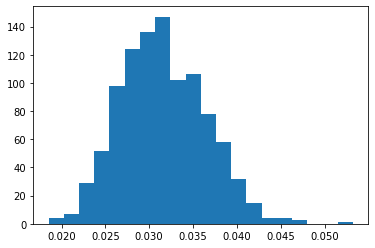

In [ ]:
x_myRandom = np.array(calculatedMetrics)
plt.hist(x_myRandom, bins = 20)

(array([  4.,  11.,  18.,  31.,  58., 118., 135., 108., 132., 108.,  91.,
         67.,  48.,  26.,  20.,   9.,   6.,   5.,   3.,   2.]),
 array([0.01876624, 0.02032201, 0.02187778, 0.02343354, 0.02498931,
        0.02654508, 0.02810085, 0.02965662, 0.03121239, 0.03276815,
        0.03432392, 0.03587969, 0.03743546, 0.03899123, 0.04054699,
        0.04210276, 0.04365853, 0.0452143 , 0.04677007, 0.04832583,
        0.0498816 ]),
 <BarContainer object of 20 artists>)

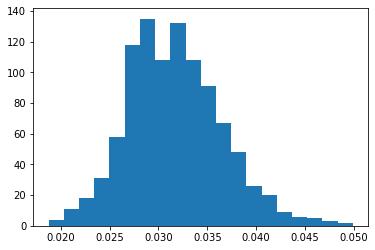

In [ ]:
x_originalRandom = np.array(calculatedMetricsPurerandom)
plt.hist(x_originalRandom, bins = 20)

In [ ]:
metric_train(A_QRT, beta_QRT) # public metric: 0.03535

0.04578782187329136

# Gradients

Attempting to move orthogonal to matrix A to calculate the gradient of metric_train w.r.t. A

The plan of attact to use the following steps:
$$
A = G X_{k}^T - X_{k} G^T
\\
\\
Q = (I + \frac{\alpha}{2} A)^{-1}(I - \frac{\alpha}{2} A)
\\
\\
X_{k+1} = Q X_{k}
$$

A here is not the same as the A in the challenge description. A here is a skew-symmetric matrix used to calculate the Cayley transform Q. X here represents the matrix A in the challenge description. Alpha is the step size from $ X_{k}$ to $X_{k+1}$. $G = \nabla F(X)$ here is the gradient of $F(X)$, the metric_train function, with respect to X.

In [114]:
X, M = randomA()
if (checkOrthonormality(X)):
    beta = fitBeta(X)
    print("X is orthonormal")
else:
    print("X is not orthonormal")

X is orthonormal


In [116]:
alpha = 0.001 # Set the step size, alpha

In [123]:
metric_train(X, beta) # public metric: 0.03535

0.0303570453422149

Calculate the gradient, $G = \nabla F(X)$, of metric_train w.r.t. A

In [ ]:
h = 0.000001 # step size for numerical gradient
grad = np.zeros((250, 10)) # gradient matrix
C = X
for i in range(250):
    print(i)
    for j in range(10):
        C[i, j] += h
        C_beta = fitBeta(C)
        # print(checkOrthonormality(A))
        grad[i, j] = (metric_train(C, C_beta) - metric_train(X, beta))/h
        # print(f"grad[{i}, {j}] = {grad[i, j]}")
        C[i, j] -= h

In [119]:
G = grad

Calcuate A
$$
A = G X_{k}^T - X_{k} G^T
$$

In [124]:
A = G@X.T - X@G.T

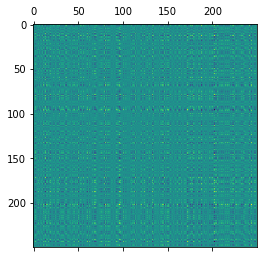

In [125]:
plt.matshow(A)

We know that by construction, A should be skew-symmetric. We can check this by seeing if A.T is close to -A. If it is, then $A.T+A \approx 0$, which means A is skew-symmetric.

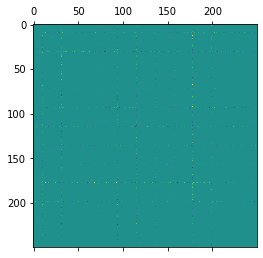

In [133]:
plt.matshow(A.T + A)

We can see that this matrix is close to zero but there are some collumns and rows that are not close to zero. This means that A is almost skew symmetric

Carring on, we will try to apply the rest of the method to see if it works:
$$
Q = (I + \frac{\alpha}{2} A)^{-1}(I - \frac{\alpha}{2} A)
$$


In [134]:
A.shape

(250, 250)

In [135]:
Q = np.linalg.inv((np.eye(250) + alpha/2*A)) @ (np.eye(250) - alpha/2*A)

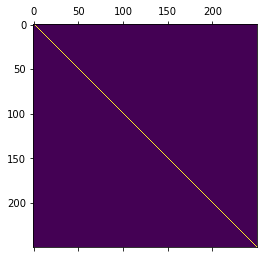

In [137]:
plt.matshow(Q)

In [138]:
X_next = Q@X

In [139]:
checkOrthonormality(X_next)

True

In [140]:
beta_next = fitBeta(X_next)

In [141]:
metric_train(X_next, beta_next) # public metric: 0.03535

0.03035533433022276

In [ ]:
0.0303570453422149

Yahoodey! We have a method of finding another solution to the problem that is also Orthonormal! We can now make some improvements to the code so that we can iterate quickly between these results to try to improve the metric_train value!! This is excellent progress!

Currently, the limiting factor in fast iteration is calculating $G$, the gradient of metric_train. Let's explore how to speed this up.

# Reducing time complexity

Let's start by collecting the project into one place and accuratelt describing each of teh variables and functions. We will then create a create a sequence of these functions in the order that we wish to execute them.
After that, we can perform timing with the time.perf_counter() function to see how long each function takes to execute. We can then use this information to see where we can improve the code.

## Start by generating a Random Stiefel Matrix A.

In [153]:
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return (randomStiefel)

## Define the beta fitting function

In [154]:
def fitBeta(A):
    predictors = X_train_reshape @ A
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()

## Define the metric function $F(A)$

In [149]:
def metric_train(A, beta): 
    
    if not checkOrthonormality(A): ## If we believe our update method is correct, this should never happen, but it may be useful for debugging
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T  # investigate which is faster: unstack or pivot and if it's easier to precompute any of this
    Ytrue = Y_train  # doesn't need to be calculated every time
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)  # This can be precomputed
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1) # can any of this be improved?

    meanOverlap = (Ytrue * Ypred).sum().mean() # can this be improved?

    return  1/meanOverlap ## Use the inverse of the mean overlap as the metric since this is a minimisation problem

## Calculate the error metric for the current matrix, $A$

In [173]:
A = randomA()
beta = fitBeta(A)
current_metric = metric_train(A, beta)
print(f"Current metric: {round(current_metric, 2)}, equivalent to {round(1/current_metric, 4)} overlap")

Current metric: 47.36, equivalent to 0.0211 overlap
(250, 10)


## Calculate the gradient of the metric function, $G = \nabla F(A)$

Current runtime for the gradient calculation is around 1 second per loop, or 250 seconds for 250 loops. This is not good enough. We need to find a way to speed this up.

In [174]:
import time
h = 0.000001 # step size for numerical gradient
G = np.zeros((250, 10)) # gradient matrix
C = A # copy of A
start = time.perf_counter()
print(A.shape)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        C[i, j] += h
        C_beta = fitBeta(C)
        # print(checkOrthonormality(A))
        G[i, j] = (metric_train(C, C_beta) - metric_train(A, beta))/h
        # print(f"grad[{i}, {j}] = {grad[i, j]}")
        C[i, j] -= h
end = time.perf_counter()
print(f"Time taken: {round(end-start, 2)} seconds")

(250, 10)
Time taken: 269.3 seconds


In [ ]:
## Calculate the gradient of a function given a matrix as the input
def calculateGradient(A, metric_train, fitBeta, h=0.000001):
    G = np.zeros((A.shape[0], A.shape[1])) # gradient matrix
    C = A # copy of A
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            C[i, j] += h
            C_beta = fitBeta(C)
            G[i, j] = (metric_train(C, C_beta) - metric_train(A, beta))/h
            C[i, j] -= h
    return G

## Calcuate X
$$
X = G A_{k}^T - A_{k} G^T
$$

In [176]:
X = G@A.T - A@G.T

## Calculate the Cayley Transform, $Q$
$$
Q = (I + \frac{\alpha}{2} X)^{-1}(I - \frac{\alpha}{2} X)
$$
with step size $\alpha = 0.001$

In [177]:
alpha = 0.001

In [178]:
X.shape

(250, 250)

In [179]:
Q = np.linalg.inv((np.eye(X.shape[0]) + alpha/2*X)) @ (np.eye(X.shape[0]) - alpha/2*X)

## Apply the update rule to $A_{k}$ to get $A_{k+1}$
$A_{k+1} = Q A_{k}$

Grab the error metric from before.

In [183]:
metric_train(A, beta)
print(f"Current metric: {round(current_metric, 2)}, equivalent to {round(1/current_metric, 4)} overlap")

Current metric: 47.36, equivalent to 0.0211 overlap


In [184]:
A_next = Q@A
beta_next = fitBeta(A_next)
new_metric = metric_train(A_next, beta_next)
print(f"Current metric: {round(new_metric, 2)}, equivalent to {round(1/new_metric, 4)} overlap")

Current metric: 28.61, equivalent to 0.035 overlap


We can see that the mean ovelap has been increase from 0.0211 to 0.035 which is a 65% increase.

In [ ]:
A = randomA()
beta = fitBeta(A)
alpha = 0.001
h = 0.000001 # step size for numerical gradient
list_of_metrics = []


Let's create a pipeline now that will automatically step through the following procedure 10 times and see if we can improve the metric!

# Postprocessing

## From $(A, \beta)$ to the output csv format

In [ ]:
def parametersTransform(A, beta, D=250, F=10):
    
    if A.shape != (D, F):
        print('A has not the good shape')
        return
    
    if beta.shape[0] != F:
        print('beta has not the good shape')
        return        
    
    output = np.hstack( (np.hstack([A.T, beta.reshape((F, 1))])).T )
    
    return output

In [ ]:
# random submission example
np.random.seed(1234)

A = randomA()
beta = np.random.rand(10)

# from output to csv file...
output = parametersTransform(A, beta)
pd.DataFrame(output).to_csv(path + 'submissionExample.csv')

# ... and back
output_fromCsv = pd.read_csv(path + 'submissionExample.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))

AttributeError: 'tuple' object has no attribute 'shape'